In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
model = fasttext.load_model("cc.en.300.bin")

In [4]:
word_embedding = model.get_word_vector('hello')
print(word_embedding)

[ 1.57576188e-01  4.37820926e-02 -4.51271934e-03  6.65931404e-02
  7.70346820e-02  4.85855248e-03  8.19822028e-03  6.52402919e-03
  9.25899856e-03  3.53899002e-02 -2.31395271e-02 -4.91807126e-02
 -8.32642540e-02  1.56014524e-02  2.54856616e-01  3.45423706e-02
 -1.07451361e-02 -7.80188590e-02 -7.08099529e-02  7.62385577e-02
 -6.09613657e-02  4.48625796e-02 -7.29744136e-02  1.30583309e-02
  3.14881057e-02 -3.10055036e-02  1.66004002e-02  1.74405202e-02
 -7.35838860e-02  1.18252613e-01 -1.21330231e-01 -4.09253240e-02
  2.93969568e-02  4.84445989e-02 -1.33816330e-02 -1.74765270e-02
  7.51308873e-02  9.97046307e-02 -4.00476977e-02  4.05735290e-03
 -7.21896589e-02 -4.43356819e-02 -1.22628408e-03  7.56693557e-02
  3.98401320e-02  3.22643593e-02  1.95914153e-02  4.68016043e-02
 -1.46228177e-02  1.12967767e-01  3.15065160e-02 -1.02312110e-01
  1.58124104e-01 -2.76147053e-02 -3.39851156e-02 -1.77006852e-02
 -5.73529862e-04  1.10789239e-01 -1.64533369e-02 -3.14955460e-03
 -4.22914140e-02  1.11429

In [5]:
def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
                embedding.append(model.get_word_vector(word))
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 70 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(model.get_word_vector("Hello"))] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_45940/937020881.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [7]:
x_train.size()

torch.Size([8019, 70, 300])

In [8]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [9]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [10]:
y_train.size()

torch.Size([8019, 70])

In [11]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


/home/bsumit43/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class RNNTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = RNNTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_45940/1893452685.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_45940/1893452685.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_45940/1893452685.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_45940/1893452685.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Epoch 1/130, Train Loss: 1.2725436015734597, Val Loss: 0.9060953855514526, Val F1: 0.03384404260269808, Train F1: 0.033231576213843185


  2%|▋                                          | 2/130 [00:04<05:15,  2.46s/it]

Epoch 2/130, Train Loss: 0.8408915646492489, Val Loss: 0.7678815126419067, Val F1: 0.04406996329303312, Train F1: 0.038652400286932766


  2%|▉                                          | 3/130 [00:07<05:10,  2.45s/it]

Epoch 3/130, Train Loss: 0.7478121935375153, Val Loss: 0.7098474502563477, Val F1: 0.052588173590768963, Train F1: 0.05015389926283888


  3%|█▎                                         | 4/130 [00:09<05:08,  2.45s/it]

Epoch 4/130, Train Loss: 0.6849265354020255, Val Loss: 0.643936038017273, Val F1: 0.058942546286511986, Train F1: 0.05652875637037011


  4%|█▋                                         | 5/130 [00:12<05:05,  2.44s/it]

Epoch 5/130, Train Loss: 0.6236664141927447, Val Loss: 0.5854059457778931, Val F1: 0.08258564898371905, Train F1: 0.068712330070491


  5%|█▉                                         | 6/130 [00:14<05:02,  2.44s/it]

Epoch 6/130, Train Loss: 0.5672229116871244, Val Loss: 0.5349564552307129, Val F1: 0.1290083362848493, Train F1: 0.11020173048094503


  5%|██▎                                        | 7/130 [00:17<05:01,  2.45s/it]

Epoch 7/130, Train Loss: 0.526950254326775, Val Loss: 0.5035285353660583, Val F1: 0.15948514467274943, Train F1: 0.14573287995223785


  6%|██▋                                        | 8/130 [00:19<05:08,  2.53s/it]

Epoch 8/130, Train Loss: 0.4995238236964695, Val Loss: 0.4813483655452728, Val F1: 0.21561136555120336, Train F1: 0.1829513909685725


  7%|██▉                                        | 9/130 [00:22<05:05,  2.52s/it]

Epoch 9/130, Train Loss: 0.48192710772393244, Val Loss: 0.4703974425792694, Val F1: 0.21701462671381014, Train F1: 0.21578395559875352


  8%|███▏                                      | 10/130 [00:24<04:59,  2.50s/it]

Epoch 10/130, Train Loss: 0.4680744442674849, Val Loss: 0.45642605423927307, Val F1: 0.2238393093289941, Train F1: 0.22977871333814004


  8%|███▌                                      | 11/130 [00:27<04:54,  2.48s/it]

Epoch 11/130, Train Loss: 0.45504768784084015, Val Loss: 0.44474756717681885, Val F1: 0.2461422559194316, Train F1: 0.24280036676874675


  9%|███▉                                      | 12/130 [00:29<04:50,  2.46s/it]

Epoch 12/130, Train Loss: 0.4478468440827869, Val Loss: 0.4374488294124603, Val F1: 0.25944781503758246, Train F1: 0.25040933601144516


 10%|████▏                                     | 13/130 [00:32<04:47,  2.46s/it]

Epoch 13/130, Train Loss: 0.43527029998718747, Val Loss: 0.4302481412887573, Val F1: 0.26658850015204355, Train F1: 0.25906069302187495


 11%|████▌                                     | 14/130 [00:34<04:43,  2.45s/it]

Epoch 14/130, Train Loss: 0.42756544266428265, Val Loss: 0.429484486579895, Val F1: 0.26627917806384277, Train F1: 0.2653684724128021


 12%|████▊                                     | 15/130 [00:36<04:40,  2.44s/it]

Epoch 15/130, Train Loss: 0.42254221675887943, Val Loss: 0.4191439151763916, Val F1: 0.27119880771553867, Train F1: 0.27095217334818117


 12%|█████▏                                    | 16/130 [00:39<04:38,  2.44s/it]

Epoch 16/130, Train Loss: 0.4150761365890503, Val Loss: 0.4182378947734833, Val F1: 0.2647982161839466, Train F1: 0.2779886591257919


 13%|█████▍                                    | 17/130 [00:41<04:36,  2.44s/it]

Epoch 17/130, Train Loss: 0.4087348897305746, Val Loss: 0.4095393419265747, Val F1: 0.2867493997121417, Train F1: 0.28428917774974066


 14%|█████▊                                    | 18/130 [00:44<04:34,  2.45s/it]

Epoch 18/130, Train Loss: 0.40510589972374933, Val Loss: 0.4081609547138214, Val F1: 0.28560411366749117, Train F1: 0.2911247620825678


 15%|██████▏                                   | 19/130 [00:46<04:32,  2.46s/it]

Epoch 19/130, Train Loss: 0.40077851121387786, Val Loss: 0.40630605816841125, Val F1: 0.29695569216695467, Train F1: 0.29459990132513325


 15%|██████▍                                   | 20/130 [00:49<04:32,  2.48s/it]

Epoch 20/130, Train Loss: 0.3972176034299154, Val Loss: 0.4018833339214325, Val F1: 0.2849105420299671, Train F1: 0.30331613104581984


 16%|██████▊                                   | 21/130 [00:51<04:29,  2.47s/it]

Epoch 21/130, Train Loss: 0.39054197829867165, Val Loss: 0.39840537309646606, Val F1: 0.3065293324360464, Train F1: 0.3108621034126117


 17%|███████                                   | 22/130 [00:54<04:25,  2.46s/it]

Epoch 22/130, Train Loss: 0.38669535517692566, Val Loss: 0.39814072847366333, Val F1: 0.31236066952935315, Train F1: 0.31628488391932913


 18%|███████▍                                  | 23/130 [00:56<04:22,  2.46s/it]

Epoch 23/130, Train Loss: 0.3839360347815922, Val Loss: 0.39341768622398376, Val F1: 0.3071702921103776, Train F1: 0.32090123821362193


 18%|███████▊                                  | 24/130 [00:59<04:20,  2.46s/it]

Epoch 24/130, Train Loss: 0.37874835776904275, Val Loss: 0.38987693190574646, Val F1: 0.32143719562779177, Train F1: 0.32376536675001827


 19%|████████                                  | 25/130 [01:01<04:16,  2.45s/it]

Epoch 25/130, Train Loss: 0.3777206440766652, Val Loss: 0.39018017053604126, Val F1: 0.3370753103500899, Train F1: 0.3332891589002702


 20%|████████▍                                 | 26/130 [01:03<04:13,  2.44s/it]

Epoch 26/130, Train Loss: 0.37284916024359444, Val Loss: 0.38941970467567444, Val F1: 0.3437441017995746, Train F1: 0.34173153394133776


 21%|████████▋                                 | 27/130 [01:06<04:10,  2.43s/it]

Epoch 27/130, Train Loss: 0.37144939766989815, Val Loss: 0.3908824026584625, Val F1: 0.34402300455891804, Train F1: 0.3463996472078278


 22%|█████████                                 | 28/130 [01:08<04:07,  2.43s/it]

Epoch 28/130, Train Loss: 0.36758571579342797, Val Loss: 0.3855757415294647, Val F1: 0.3345701834808572, Train F1: 0.3487279414718748


 22%|█████████▎                                | 29/130 [01:11<04:04,  2.42s/it]

Epoch 29/130, Train Loss: 0.3645787508714767, Val Loss: 0.3856571614742279, Val F1: 0.32122047029358425, Train F1: 0.3567308176426487


 23%|█████████▋                                | 30/130 [01:13<04:02,  2.42s/it]

Epoch 30/130, Train Loss: 0.3615275540995219, Val Loss: 0.3839236795902252, Val F1: 0.36049292411040557, Train F1: 0.36100876837169854


 24%|██████████                                | 31/130 [01:16<04:01,  2.44s/it]

Epoch 31/130, Train Loss: 0.35850950460585335, Val Loss: 0.3804091811180115, Val F1: 0.3461914649769114, Train F1: 0.36555710404555747


 25%|██████████▎                               | 32/130 [01:18<03:59,  2.45s/it]

Epoch 32/130, Train Loss: 0.35638661895479473, Val Loss: 0.3782047629356384, Val F1: 0.35402923608083087, Train F1: 0.3683697443252629


 25%|██████████▋                               | 33/130 [01:21<04:01,  2.49s/it]

Epoch 33/130, Train Loss: 0.352415670005102, Val Loss: 0.37855592370033264, Val F1: 0.3394608599753224, Train F1: 0.3759956628890725


 26%|██████████▉                               | 34/130 [01:23<03:59,  2.50s/it]

Epoch 34/130, Train Loss: 0.3505859441227383, Val Loss: 0.37667033076286316, Val F1: 0.36659120020753727, Train F1: 0.3779020788134806


 27%|███████████▎                              | 35/130 [01:26<03:55,  2.48s/it]

Epoch 35/130, Train Loss: 0.3494970401128133, Val Loss: 0.37537211179733276, Val F1: 0.3742769109553805, Train F1: 0.3822747210295953


 28%|███████████▋                              | 36/130 [01:28<03:52,  2.47s/it]

Epoch 36/130, Train Loss: 0.3467275703710223, Val Loss: 0.37475714087486267, Val F1: 0.3691365674764992, Train F1: 0.3823197399162588


 28%|███████████▉                              | 37/130 [01:30<03:48,  2.45s/it]

Epoch 37/130, Train Loss: 0.3442601670348455, Val Loss: 0.3761853873729706, Val F1: 0.37683764979928697, Train F1: 0.3919347677463744


 29%|████████████▎                             | 38/130 [01:33<03:45,  2.45s/it]

Epoch 38/130, Train Loss: 0.341929867154076, Val Loss: 0.37418100237846375, Val F1: 0.37636462513825425, Train F1: 0.38756680244525615


 30%|████████████▌                             | 39/130 [01:35<03:42,  2.44s/it]

Epoch 39/130, Train Loss: 0.33920466616040185, Val Loss: 0.37849652767181396, Val F1: 0.37441496473717695, Train F1: 0.39727224891871765


 31%|████████████▉                             | 40/130 [01:38<03:39,  2.44s/it]

Epoch 40/130, Train Loss: 0.3376613571530297, Val Loss: 0.3727237284183502, Val F1: 0.3909494327000949, Train F1: 0.39567491040034386


 32%|█████████████▏                            | 41/130 [01:40<03:36,  2.43s/it]

Epoch 41/130, Train Loss: 0.3352433145046234, Val Loss: 0.3767811357975006, Val F1: 0.3633722859549809, Train F1: 0.40075566149567776


 32%|█████████████▌                            | 42/130 [01:43<03:36,  2.46s/it]

Epoch 42/130, Train Loss: 0.3342437313662635, Val Loss: 0.3682706356048584, Val F1: 0.38490925880476257, Train F1: 0.40476581659172384


 33%|█████████████▉                            | 43/130 [01:45<03:33,  2.45s/it]

Epoch 43/130, Train Loss: 0.32949717271895634, Val Loss: 0.3706369400024414, Val F1: 0.3731931825672397, Train F1: 0.4094605344494713


 34%|██████████████▏                           | 44/130 [01:48<03:30,  2.44s/it]

Epoch 44/130, Train Loss: 0.328071395556132, Val Loss: 0.3695197105407715, Val F1: 0.37811227357305127, Train F1: 0.410059656989821


 35%|██████████████▌                           | 45/130 [01:50<03:26,  2.43s/it]

Epoch 45/130, Train Loss: 0.32647350430488586, Val Loss: 0.37039366364479065, Val F1: 0.38272517613688833, Train F1: 0.4143053330711384


 35%|██████████████▊                           | 46/130 [01:52<03:23,  2.43s/it]

Epoch 46/130, Train Loss: 0.32462833798120894, Val Loss: 0.375676691532135, Val F1: 0.38682833032998576, Train F1: 0.4176904226568432


 36%|███████████████▏                          | 47/130 [01:55<03:21,  2.43s/it]

Epoch 47/130, Train Loss: 0.321740086116488, Val Loss: 0.37163665890693665, Val F1: 0.3808296974820238, Train F1: 0.41800410233374236


 37%|███████████████▌                          | 48/130 [01:57<03:19,  2.43s/it]

Epoch 48/130, Train Loss: 0.32254294696308317, Val Loss: 0.372629314661026, Val F1: 0.3886134849420948, Train F1: 0.42158081290865457


 38%|███████████████▊                          | 49/130 [02:00<03:18,  2.44s/it]

Epoch 49/130, Train Loss: 0.31941295143157716, Val Loss: 0.37161460518836975, Val F1: 0.40393779676277386, Train F1: 0.42314042809587815


 38%|████████████████▏                         | 50/130 [02:02<03:15,  2.44s/it]

Epoch 50/130, Train Loss: 0.31490617777620045, Val Loss: 0.37053731083869934, Val F1: 0.39178374783956393, Train F1: 0.4293516611204823


 39%|████████████████▍                         | 51/130 [02:05<03:12,  2.43s/it]

Epoch 51/130, Train Loss: 0.31578680589085534, Val Loss: 0.3733242154121399, Val F1: 0.37983710241831353, Train F1: 0.4263740095230978


 40%|████████████████▊                         | 52/130 [02:07<03:09,  2.43s/it]

Epoch 52/130, Train Loss: 0.3155882263940478, Val Loss: 0.3707973062992096, Val F1: 0.40075817776433054, Train F1: 0.42847201904707827


 41%|█████████████████                         | 53/130 [02:09<03:08,  2.45s/it]

Epoch 53/130, Train Loss: 0.31170981956852806, Val Loss: 0.3710133731365204, Val F1: 0.4062845172919311, Train F1: 0.43765504658534016


 42%|█████████████████▍                        | 54/130 [02:12<03:05,  2.44s/it]

Epoch 54/130, Train Loss: 0.3112810869065542, Val Loss: 0.3727720379829407, Val F1: 0.4050612733244146, Train F1: 0.4410759122101001


 42%|█████████████████▊                        | 55/130 [02:14<03:02,  2.44s/it]

Epoch 55/130, Train Loss: 0.30811462705097503, Val Loss: 0.3705383837223053, Val F1: 0.4010177887085649, Train F1: 0.44182347652760234


 43%|██████████████████                        | 56/130 [02:17<03:00,  2.43s/it]

Epoch 56/130, Train Loss: 0.306529329409675, Val Loss: 0.3704453110694885, Val F1: 0.3932332829309186, Train F1: 0.44220454298526435


 44%|██████████████████▍                       | 57/130 [02:19<02:57,  2.43s/it]

Epoch 57/130, Train Loss: 0.30229067991650294, Val Loss: 0.3710134029388428, Val F1: 0.40495470202948985, Train F1: 0.4552496051160089


 45%|██████████████████▋                       | 58/130 [02:22<02:54,  2.42s/it]

Epoch 58/130, Train Loss: 0.30093098940357327, Val Loss: 0.3740187883377075, Val F1: 0.39972917447064316, Train F1: 0.4498060335301742


 45%|███████████████████                       | 59/130 [02:24<02:51,  2.42s/it]

Epoch 59/130, Train Loss: 0.30075243754046305, Val Loss: 0.376213014125824, Val F1: 0.406984319430535, Train F1: 0.4494652131951334


 46%|███████████████████▍                      | 60/130 [02:26<02:49,  2.42s/it]

Epoch 60/130, Train Loss: 0.300659068520107, Val Loss: 0.3836795389652252, Val F1: 0.36911744651765804, Train F1: 0.455383138470746


 47%|███████████████████▋                      | 61/130 [02:29<02:47,  2.42s/it]

Epoch 61/130, Train Loss: 0.29871631662050885, Val Loss: 0.37529364228248596, Val F1: 0.40201155647070846, Train F1: 0.4533333766147302


 48%|████████████████████                      | 62/130 [02:31<02:44,  2.42s/it]

Epoch 62/130, Train Loss: 0.29353803112393334, Val Loss: 0.37249472737312317, Val F1: 0.41199523117437875, Train F1: 0.4595206456611848


 48%|████████████████████▎                     | 63/130 [02:34<02:42,  2.42s/it]

Epoch 63/130, Train Loss: 0.29295554520591854, Val Loss: 0.3762533664703369, Val F1: 0.4047396077057216, Train F1: 0.46647789094302533


 49%|████████████████████▋                     | 64/130 [02:36<02:41,  2.45s/it]

Epoch 64/130, Train Loss: 0.2921750947596535, Val Loss: 0.37625497579574585, Val F1: 0.3997826208524388, Train F1: 0.46480043575786145


 50%|█████████████████████                     | 65/130 [02:39<02:38,  2.44s/it]

Epoch 65/130, Train Loss: 0.2901855917677047, Val Loss: 0.3760608434677124, Val F1: 0.41188873784674174, Train F1: 0.46702566709746873


 51%|█████████████████████▎                    | 66/130 [02:41<02:36,  2.44s/it]

Epoch 66/130, Train Loss: 0.2879152846714807, Val Loss: 0.3752135932445526, Val F1: 0.40914766089072113, Train F1: 0.4682627717316299


 52%|█████████████████████▋                    | 67/130 [02:43<02:33,  2.43s/it]

Epoch 67/130, Train Loss: 0.28509531300219276, Val Loss: 0.38004645705223083, Val F1: 0.3954053578538537, Train F1: 0.47481069727794606


 52%|█████████████████████▉                    | 68/130 [02:46<02:31,  2.44s/it]

Epoch 68/130, Train Loss: 0.284632551764685, Val Loss: 0.38013923168182373, Val F1: 0.4057258613040134, Train F1: 0.47530756154706655


 53%|██████████████████████▎                   | 69/130 [02:48<02:28,  2.43s/it]

Epoch 69/130, Train Loss: 0.2830147402627127, Val Loss: 0.3859524130821228, Val F1: 0.40002106474569793, Train F1: 0.4782830845340927


 54%|██████████████████████▌                   | 70/130 [02:51<02:25,  2.43s/it]

Epoch 70/130, Train Loss: 0.2814294203879341, Val Loss: 0.38399553298950195, Val F1: 0.39966600289390863, Train F1: 0.4817862668298825


 55%|██████████████████████▉                   | 71/130 [02:53<02:22,  2.42s/it]

Epoch 71/130, Train Loss: 0.28043806174444774, Val Loss: 0.3882604241371155, Val F1: 0.40028313227553664, Train F1: 0.4803070389194313


 55%|███████████████████████▎                  | 72/130 [02:56<02:20,  2.43s/it]

Epoch 72/130, Train Loss: 0.27774225837654537, Val Loss: 0.38347187638282776, Val F1: 0.4099738412058396, Train F1: 0.4839968503424674


 56%|███████████████████████▌                  | 73/130 [02:58<02:17,  2.42s/it]

Epoch 73/130, Train Loss: 0.2762364641068474, Val Loss: 0.38990920782089233, Val F1: 0.38644066786311704, Train F1: 0.488673134155632


 57%|███████████████████████▉                  | 74/130 [03:00<02:15,  2.42s/it]

Epoch 74/130, Train Loss: 0.2740945208167273, Val Loss: 0.3816719651222229, Val F1: 0.4047061993733237, Train F1: 0.48930073078549674


 58%|████████████████████████▏                 | 75/130 [03:03<02:14,  2.45s/it]

Epoch 75/130, Train Loss: 0.2744607449997039, Val Loss: 0.3928898870944977, Val F1: 0.4122261272750941, Train F1: 0.49158811740173514


 58%|████████████████████████▌                 | 76/130 [03:05<02:11,  2.44s/it]

Epoch 76/130, Train Loss: 0.2698676009026785, Val Loss: 0.39017021656036377, Val F1: 0.40873020891761896, Train F1: 0.501630841879197


 59%|████████████████████████▉                 | 77/130 [03:08<02:09,  2.44s/it]

Epoch 77/130, Train Loss: 0.2711047390623698, Val Loss: 0.39636269211769104, Val F1: 0.3855673402826638, Train F1: 0.495388695413342


 60%|█████████████████████████▏                | 78/130 [03:10<02:06,  2.43s/it]

Epoch 78/130, Train Loss: 0.268210804651654, Val Loss: 0.399753600358963, Val F1: 0.3900271659455168, Train F1: 0.5020106554751473


 61%|█████████████████████████▌                | 79/130 [03:13<02:03,  2.42s/it]

Epoch 79/130, Train Loss: 0.26794996006148203, Val Loss: 0.40021851658821106, Val F1: 0.39525359706227553, Train F1: 0.5039533924892677


 62%|█████████████████████████▊                | 80/130 [03:15<02:00,  2.42s/it]

Epoch 80/130, Train Loss: 0.26490412274050334, Val Loss: 0.4051312804222107, Val F1: 0.39135164027040864, Train F1: 0.507790141522635


 62%|██████████████████████████▏               | 81/130 [03:17<01:58,  2.42s/it]

Epoch 81/130, Train Loss: 0.26218972485216835, Val Loss: 0.39513662457466125, Val F1: 0.39124603593172197, Train F1: 0.5068030047073049


 63%|██████████████████████████▍               | 82/130 [03:20<01:55,  2.41s/it]

Epoch 82/130, Train Loss: 0.26092029753185453, Val Loss: 0.40814751386642456, Val F1: 0.39244364409638244, Train F1: 0.5129311771739046


 64%|██████████████████████████▊               | 83/130 [03:22<01:53,  2.41s/it]

Epoch 83/130, Train Loss: 0.25989854525006006, Val Loss: 0.4009496569633484, Val F1: 0.391473580317649, Train F1: 0.5157422434361341


 65%|███████████████████████████▏              | 84/130 [03:25<01:50,  2.41s/it]

Epoch 84/130, Train Loss: 0.2590753977733945, Val Loss: 0.39951542019844055, Val F1: 0.4008758820329287, Train F1: 0.5102271526765747


 65%|███████████████████████████▍              | 85/130 [03:27<01:48,  2.41s/it]

Epoch 85/130, Train Loss: 0.3030672229471661, Val Loss: 0.4033699333667755, Val F1: 0.38282307832406937, Train F1: 0.4799514702972147


 66%|███████████████████████████▊              | 86/130 [03:30<01:47,  2.43s/it]

Epoch 86/130, Train Loss: 0.27305213019015295, Val Loss: 0.39348387718200684, Val F1: 0.400538561023477, Train F1: 0.49875331686904134


 67%|████████████████████████████              | 87/130 [03:32<01:44,  2.42s/it]

Epoch 87/130, Train Loss: 0.2592524630682809, Val Loss: 0.3903891146183014, Val F1: 0.3985723127981138, Train F1: 0.5147639249254349


 68%|████████████████████████████▍             | 88/130 [03:34<01:41,  2.42s/it]

Epoch 88/130, Train Loss: 0.2557992585121639, Val Loss: 0.39879751205444336, Val F1: 0.3994716066328511, Train F1: 0.526036688222141


 68%|████████████████████████████▊             | 89/130 [03:37<01:39,  2.42s/it]

Epoch 89/130, Train Loss: 0.2536925964412235, Val Loss: 0.4112577438354492, Val F1: 0.38832288636357387, Train F1: 0.5285452268108174


 69%|█████████████████████████████             | 90/130 [03:39<01:36,  2.41s/it]

Epoch 90/130, Train Loss: 0.25043769582869513, Val Loss: 0.40241044759750366, Val F1: 0.3992480817205149, Train F1: 0.5304992214863605


 70%|█████████████████████████████▍            | 91/130 [03:42<01:34,  2.42s/it]

Epoch 91/130, Train Loss: 0.24874529029641831, Val Loss: 0.4045983552932739, Val F1: 0.3985041724004307, Train F1: 0.5298006035155624


 71%|█████████████████████████████▋            | 92/130 [03:44<01:31,  2.42s/it]

Epoch 92/130, Train Loss: 0.24558108808502319, Val Loss: 0.4038662016391754, Val F1: 0.4038220360661099, Train F1: 0.5389237886760265


 72%|██████████████████████████████            | 93/130 [03:46<01:29,  2.42s/it]

Epoch 93/130, Train Loss: 0.245329039910483, Val Loss: 0.40952926874160767, Val F1: 0.3961670362328809, Train F1: 0.5365604625824217


 72%|██████████████████████████████▎           | 94/130 [03:49<01:27,  2.42s/it]

Epoch 94/130, Train Loss: 0.24693272747690714, Val Loss: 0.4171200692653656, Val F1: 0.38552902664856453, Train F1: 0.5352331217967777


 73%|██████████████████████████████▋           | 95/130 [03:51<01:24,  2.43s/it]

Epoch 95/130, Train Loss: 0.2440875924768902, Val Loss: 0.4121842086315155, Val F1: 0.4049076779361065, Train F1: 0.5398497620225642


 74%|███████████████████████████████           | 96/130 [03:54<01:22,  2.43s/it]

Epoch 96/130, Train Loss: 0.24113066021412138, Val Loss: 0.41674140095710754, Val F1: 0.3937478979384714, Train F1: 0.5442828205555292


 75%|███████████████████████████████▎          | 97/130 [03:56<01:21,  2.46s/it]

Epoch 97/130, Train Loss: 0.2394970575022319, Val Loss: 0.4205680787563324, Val F1: 0.39368125380842367, Train F1: 0.5459022774368194


 75%|███████████████████████████████▋          | 98/130 [03:59<01:18,  2.45s/it]

Epoch 98/130, Train Loss: 0.2729070196076045, Val Loss: 0.4249754250049591, Val F1: 0.3796395534206531, Train F1: 0.5077459034477346


 76%|███████████████████████████████▉          | 99/130 [04:01<01:15,  2.44s/it]

Epoch 99/130, Train Loss: 0.25640186643789686, Val Loss: 0.40364450216293335, Val F1: 0.40566328731855056, Train F1: 0.522733472962364


 77%|███████████████████████████████▌         | 100/130 [04:04<01:12,  2.43s/it]

Epoch 100/130, Train Loss: 0.2402322223735234, Val Loss: 0.41066601872444153, Val F1: 0.4062206880929046, Train F1: 0.543716191657563


 78%|███████████████████████████████▊         | 101/130 [04:06<01:10,  2.43s/it]

Epoch 101/130, Train Loss: 0.2367009948643427, Val Loss: 0.4186837375164032, Val F1: 0.40318508895248817, Train F1: 0.5515255782508356


 78%|████████████████████████████████▏        | 102/130 [04:08<01:07,  2.42s/it]

Epoch 102/130, Train Loss: 0.23468930853737724, Val Loss: 0.42286375164985657, Val F1: 0.39893079370484785, Train F1: 0.5584622324883358


 79%|████████████████████████████████▍        | 103/130 [04:11<01:05,  2.42s/it]

Epoch 103/130, Train Loss: 0.2324271183165293, Val Loss: 0.4245135486125946, Val F1: 0.4003665578002434, Train F1: 0.5581389984311831


 80%|████████████████████████████████▊        | 104/130 [04:13<01:03,  2.43s/it]

Epoch 104/130, Train Loss: 0.23283154671154324, Val Loss: 0.4255916178226471, Val F1: 0.40908165831161575, Train F1: 0.5598187785396777


 81%|█████████████████████████████████        | 105/130 [04:16<01:01,  2.48s/it]

Epoch 105/130, Train Loss: 0.23055924333277203, Val Loss: 0.4360310733318329, Val F1: 0.3918429073357771, Train F1: 0.5602349380173117


 82%|█████████████████████████████████▍       | 106/130 [04:18<00:59,  2.46s/it]

Epoch 106/130, Train Loss: 0.2288731173390434, Val Loss: 0.4273698329925537, Val F1: 0.4051145542108781, Train F1: 0.5626738779884997


 82%|█████████████████████████████████▋       | 107/130 [04:21<00:56,  2.45s/it]

Epoch 107/130, Train Loss: 0.22815353411530692, Val Loss: 0.4326252043247223, Val F1: 0.3977383940438774, Train F1: 0.5662783306208253


 83%|██████████████████████████████████       | 108/130 [04:23<00:54,  2.46s/it]

Epoch 108/130, Train Loss: 0.22668366749135274, Val Loss: 0.43691232800483704, Val F1: 0.3944735823268574, Train F1: 0.5675782524326147


 84%|██████████████████████████████████▍      | 109/130 [04:26<00:51,  2.45s/it]

Epoch 109/130, Train Loss: 0.22687355369802506, Val Loss: 0.43480366468429565, Val F1: 0.3984463603606207, Train F1: 0.5687640888734437


 85%|██████████████████████████████████▋      | 110/130 [04:28<00:48,  2.44s/it]

Epoch 110/130, Train Loss: 0.22480726857033986, Val Loss: 0.4364599883556366, Val F1: 0.39517524769839796, Train F1: 0.5737374567297255


 85%|███████████████████████████████████      | 111/130 [04:30<00:46,  2.43s/it]

Epoch 111/130, Train Loss: 0.2223531206448873, Val Loss: 0.4480156898498535, Val F1: 0.3928227993600193, Train F1: 0.57284867623839


 86%|███████████████████████████████████▎     | 112/130 [04:33<00:43,  2.43s/it]

Epoch 112/130, Train Loss: 0.2218733217035021, Val Loss: 0.44027602672576904, Val F1: 0.3975849348734992, Train F1: 0.5715582866253652


 87%|███████████████████████████████████▋     | 113/130 [04:35<00:41,  2.43s/it]

Epoch 113/130, Train Loss: 0.2206572994353279, Val Loss: 0.4394948482513428, Val F1: 0.4079050019504598, Train F1: 0.5788001332348902


 88%|███████████████████████████████████▉     | 114/130 [04:38<00:38,  2.43s/it]

Epoch 114/130, Train Loss: 0.21967530912823147, Val Loss: 0.44336411356925964, Val F1: 0.39901018717771125, Train F1: 0.5826451625056575


 88%|████████████████████████████████████▎    | 115/130 [04:40<00:36,  2.43s/it]

Epoch 115/130, Train Loss: 0.21651092999511296, Val Loss: 0.45061594247817993, Val F1: 0.3960465730808184, Train F1: 0.586748545827451


 89%|████████████████████████████████████▌    | 116/130 [04:43<00:33,  2.43s/it]

Epoch 116/130, Train Loss: 0.21627080653394973, Val Loss: 0.45653021335601807, Val F1: 0.39868147711912955, Train F1: 0.5878878034086923


 90%|████████████████████████████████████▉    | 117/130 [04:45<00:31,  2.43s/it]

Epoch 117/130, Train Loss: 0.2144007148250701, Val Loss: 0.4582124352455139, Val F1: 0.3903571034929685, Train F1: 0.5864275415609368


 91%|█████████████████████████████████████▏   | 118/130 [04:47<00:29,  2.43s/it]

Epoch 118/130, Train Loss: 0.21423154336119454, Val Loss: 0.4754480719566345, Val F1: 0.39424821306642416, Train F1: 0.5887906028589203


 92%|█████████████████████████████████████▌   | 119/130 [04:50<00:27,  2.46s/it]

Epoch 119/130, Train Loss: 0.21810054802705373, Val Loss: 0.464076429605484, Val F1: 0.3971372209565272, Train F1: 0.5849860198237187


 92%|█████████████████████████████████████▊   | 120/130 [04:52<00:24,  2.45s/it]

Epoch 120/130, Train Loss: 0.212508126383736, Val Loss: 0.4506393373012543, Val F1: 0.40311649802963206, Train F1: 0.5925269466121058


 93%|██████████████████████████████████████▏  | 121/130 [04:55<00:22,  2.45s/it]

Epoch 121/130, Train Loss: 0.20974020139565544, Val Loss: 0.46410757303237915, Val F1: 0.3940029316297017, Train F1: 0.596677907790794


 94%|██████████████████████████████████████▍  | 122/130 [04:57<00:19,  2.44s/it]

Epoch 122/130, Train Loss: 0.20715337400398556, Val Loss: 0.4658350646495819, Val F1: 0.40150335661979497, Train F1: 0.5982369527071367


 95%|██████████████████████████████████████▊  | 123/130 [05:00<00:17,  2.44s/it]

Epoch 123/130, Train Loss: 0.2068742099735472, Val Loss: 0.46971917152404785, Val F1: 0.3889237778109075, Train F1: 0.5997259090999651


 95%|███████████████████████████████████████  | 124/130 [05:02<00:14,  2.44s/it]

Epoch 124/130, Train Loss: 0.20841969857140194, Val Loss: 0.4685516655445099, Val F1: 0.39386287104922874, Train F1: 0.6023387458127578


 96%|███████████████████████████████████████▍ | 125/130 [05:05<00:12,  2.43s/it]

Epoch 125/130, Train Loss: 0.20614251234228648, Val Loss: 0.4716104567050934, Val F1: 0.3880191305037559, Train F1: 0.6064158341325171


 97%|███████████████████████████████████████▋ | 126/130 [05:07<00:09,  2.43s/it]

Epoch 126/130, Train Loss: 0.20353561190385666, Val Loss: 0.47201406955718994, Val F1: 0.3921209065999753, Train F1: 0.6056722864305178


 98%|████████████████████████████████████████ | 127/130 [05:09<00:07,  2.43s/it]

Epoch 127/130, Train Loss: 0.2042190061202125, Val Loss: 0.48014429211616516, Val F1: 0.39283243855716216, Train F1: 0.6098444528817846


 98%|████████████████████████████████████████▎| 128/130 [05:12<00:04,  2.42s/it]

Epoch 128/130, Train Loss: 0.20138305780433474, Val Loss: 0.4981590807437897, Val F1: 0.389461493616306, Train F1: 0.6114723174862418


 99%|████████████████████████████████████████▋| 129/130 [05:14<00:02,  2.43s/it]

Epoch 129/130, Train Loss: 0.2017994359845207, Val Loss: 0.4809567928314209, Val F1: 0.39039731752019413, Train F1: 0.6098655099379992


100%|█████████████████████████████████████████| 130/130 [05:17<00:00,  2.44s/it]

Epoch 130/130, Train Loss: 0.1996891519853047, Val Loss: 0.4863439202308655, Val F1: 0.3981106171593119, Train F1: 0.6117687380995878


In [13]:
# Save the model
torch.save(model.state_dict(), 't1_model1_fasttext.pth')

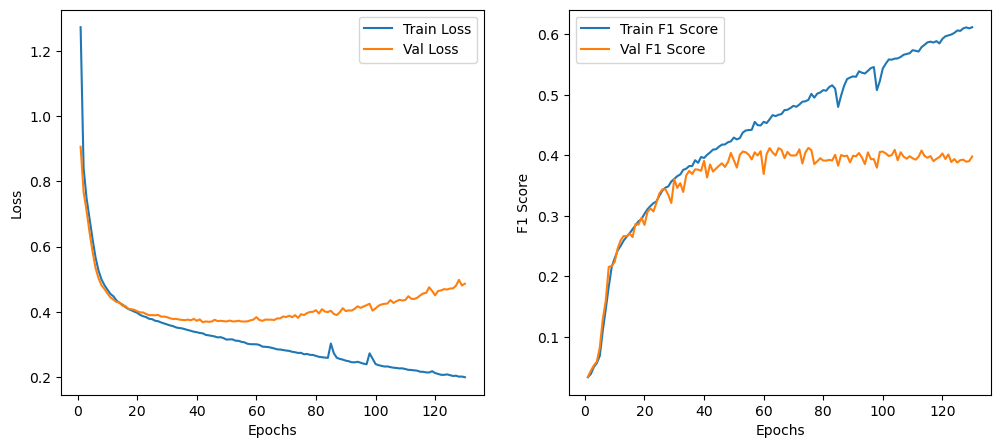

In [14]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()